In [6]:
import networkx as nx
import itertools
import collections
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit

### BINNING AND POWER LAW FITTING FUNCTIONS

In [2]:
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins, density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins

In [3]:
def powerLaw(x, a, b):
    return b*x**(a)

### NETWORK INFO

In [7]:
df=pd.read_csv('datasets/twitch_gamers/large_twitch_edges.csv')

In [8]:
df

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118
...,...,...
6797552,97507,29359
6797553,71175,12020
6797554,151702,128281
6797555,118034,38021


In [9]:
G=nx.from_pandas_edgelist(df,source='numeric_id_1',target='numeric_id_2',create_using=nx.Graph())

In [10]:
print(G)

Graph with 168114 nodes and 6797557 edges


### DEGREE DISTRIBUTION

In [11]:
kDict=dict(G.degree())

In [12]:
kValues=list(kDict.values())

(array([1.62756e+05, 3.55200e+03, 8.18000e+02, 3.40000e+02, 1.79000e+02,
        1.04000e+02, 8.30000e+01, 4.70000e+01, 3.80000e+01, 2.50000e+01,
        2.40000e+01, 1.20000e+01, 2.20000e+01, 2.10000e+01, 9.00000e+00,
        1.00000e+01, 1.10000e+01, 3.00000e+00, 1.10000e+01, 4.00000e+00,
        2.00000e+00, 4.00000e+00, 4.00000e+00, 5.00000e+00, 0.00000e+00,
        5.00000e+00, 2.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

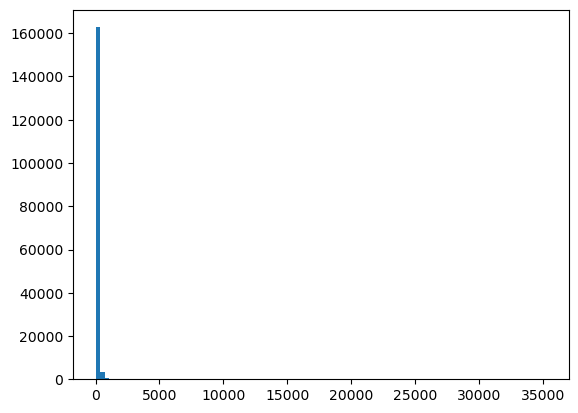

In [21]:
plt.hist(kValues,bins=100)

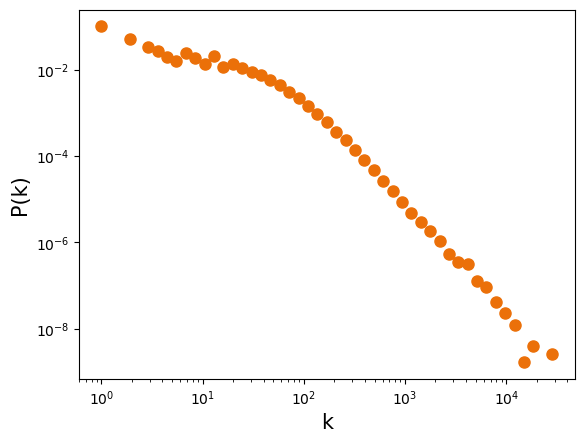

In [13]:
#https://www.computerhope.com/tips/tip143.htm

pk,k=logBinning(kValues,50)
plt.loglog(k,pk,'o',color='#EB7009',markersize=8)
plt.xlabel('k',size=15)
plt.ylabel('P(k)',size=15)
plt.show()

In [15]:
from scipy.optimize import curve_fit
import scipy.stats

fitx=[]
fity=[]
for (i,j) in zip(k,pk):
    if i>500:
        fitx.append(i)
        fity.append(j)

popt, pcov = curve_fit(powerLaw, fitx, fity)  
print (popt[0])

-2.554659337420387


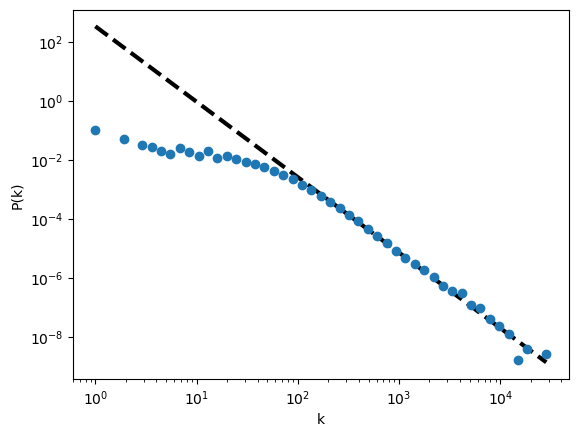

In [16]:
plt.loglog(sorted(k), powerLaw(sorted(k), *popt), '--',c='k',linewidth=3)

plt.loglog(k,pk,'o')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.show()

### DEGREE MIXING

In [18]:
#we calculate the average degree of the neighbours for each node
knn={}
for n in G.nodes():
    neighbors_degrees=[kDict[v] for v in G.neighbors(n)]
    knn[n]=np.mean(neighbors_degrees)


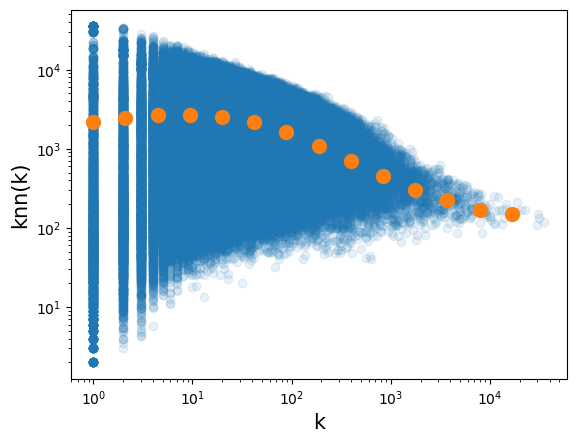

In [19]:
xx=[]
yy=[]
for n in knn.keys():
    xx.append(kDict[n])
    yy.append(knn[n])

plt.loglog(xx,yy,'o',alpha=0.1)
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
#if I use np.linspace I will have linear bins
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.show()

# RICH CLUB

In [23]:
rc = nx.rich_club_coefficient(G, normalized=False, seed=42)

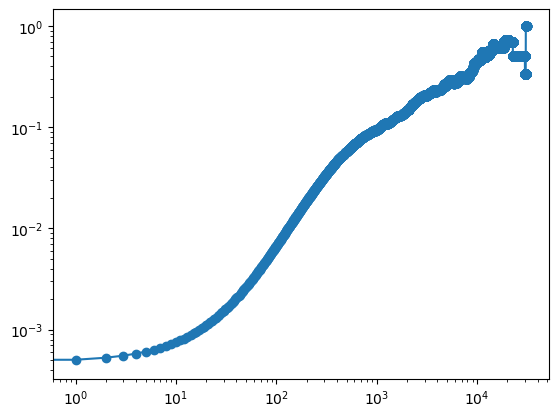

In [27]:
plt.loglog(rc.keys(),rc.values(),'o-')

# ROBUSTNESS

### RANDOM FAILURE

In [43]:
nodes_small=[i for i in G.nodes() if G.degree(i)>50]

In [44]:
len(nodes_small)

60470

In [45]:
Gs=G.subgraph(nodes_small)

In [46]:
fList=np.linspace(0,1,20)
NtoRem=[int(i*Gs.number_of_nodes()) for i in fList]

In [47]:
print(NtoRem)

[0, 3182, 6365, 9547, 12730, 15913, 19095, 22278, 25461, 28643, 31826, 35008, 38191, 41374, 44556, 47739, 50922, 54104, 57287, 60470]


In [49]:
import random
sf=[]
for nn in NtoRem[:-3]:
    thisG=Gs.copy()
    ll=random.sample(list(Gs.nodes()),nn)
    thisG.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sf.append(thisSf/float(Gs.number_of_nodes()))


ValueError: x and y must have same first dimension, but have shapes (17,) and (0,)

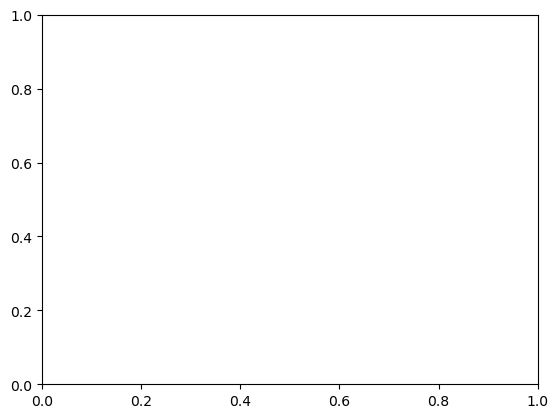

In [ ]:

plt.plot(fList[:-3],sf,'s-',markerSize=10,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.show()

### TARGET ATTACK

In [ ]:
hh=collections.Counter(dict(Gs.degree())).most_common()
orderedNodes=[u for (u,v) in hh]

In [ ]:
fList1=np.linspace(0,1,20)
NtoRem=[int(i*Gs.number_of_nodes()) for i in fList1]

In [ ]:
sfAtt=[]
for nn in NtoRem[:-1]:
    thisG=Gs.copy()
    ll=orderedNodes[:nn]
    thisG.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sfAtt.append(thisSf/float(Gs.number_of_nodes()))

In [ ]:
plt.plot(fList1[:-1],sfAtt,'o-',markerSize=10,label='attack')
plt.plot(fList[:-1],sf,'s-',markerSize=10,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.show()

# COMMUNITIES

In [28]:
C=nx.community.louvain_communities(G, seed=123)

KeyboardInterrupt: 

In [ ]:
len(C)